# Modélisation de la consommation et de la production d'un foyer équipé d'un photovoltaique, d'une éolienne et d'une batterie

Ce notebook permet de reproduire les expériences du papier :

TODO:
- inclure la prediction de la consommation
- inclure le temps de calcul
- update sources des données
- IoT peut foncitonner en temps reel mais limitation par la resolution des donnees obtenues
    
https://www.meteoblue.com/fr/historyplus
    
 
## Estimation de la consommation
On estime que le foyer a une consommation électrique annuelle de 20000 kWh[1]. Les données proviennent du gouvernement français[2]. Les heures creuses/pleines sont prises pour Cachan.

[1] http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php "Consommation moyenne d'une maison"

[2] https://www.data.gouv.fr/fr/datasets/bilan-electrique-au-pas-demi-heure/ "Dataset de consommation"

## Prix de l'électricité
http://www.kelwatt.fr/guide/prix-par-mois#base

http://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435
- Abonnement annuel : 117,50 €
- Evolution des prix sur 2013 en suivant l'historique de :
http://www.kelwatt.fr/prix/tarif-bleu-edf#trouver-moins-cher-tarif-bleu
- prix du kWh: (heures pleines, heures creuses) = 0.129, 0.105


Rachat du photovoltaïque :
- Intégration au bâti :
    0-9 kWc = 24,29 cts€/kWh (24,64 cts€/kWh le trimestre précédent)
- Intégration simplifiée au bâti :
    0-36 kW = 12,72 cts€/kWh (13,27 cts€/kWh le trimestre précédent)
    36-100 kW = 12,13 cts€/kWh (12,62 cts€/kWh le trimestre précédent)
- Sans intégration, ou hors critères ci-dessus, ou au sol:
    5,65 c€/kWh (5,96 cts€/kwh le trimestre précédent)

Rachat de l'éolien :
- http://www.developpement-durable.gouv.fr/Les-tarifs-d-achat-de-l,12195.html
- prix: 8.2cEUR/kWh

## Initialisation 1/2

In [1]:
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss



import locale, time
# locale.setlocale(locale.LC_TIME, "fr_FR".encode('ascii'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# from matplotlib import rc
# from __future__ import unicode_literals
import numpy as np
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
# rc('font',**{'family':'serif','serif':['Times']})

%matplotlib inline



# données météo 
bale=pd.read_csv('dataset/history_export_2016-12-03T18-03-27.csv', sep=";", skiprows=11)
bale["date"]=pd.to_datetime({
        'year': bale["Year"],
        'month': bale["Month"],
        'day': bale["Day"],
        'hour': bale["Hour"],
                    })
bale = bale.set_index(['date'])
bale["radiation"] = bale["Shortwave Radiation - backwards"]/1000



# données de consommation
df_14=pd.read_csv('dataset/conso_bale_2014.csv', sep=",") # attention les données de 2014 sont moins fiables : toute la Suisse
df_14['kWh']/=df_14['kWh'].sum()
df_15=pd.read_csv('dataset/conso_bale_2015.csv', sep=",")
df_15['kWh']/=df_15['kWh'].sum()
df_16=pd.read_csv('dataset/conso_bale_2016.csv', sep=",")
df_16['kWh']/=df_16['kWh'].sum()
df = pd.concat([df_14, df_15, df_16])
df["date"]=pd.to_datetime(df["date"])
df = df.set_index(['date'])
consoPerso = 20000 # consommation annuelle kWh d'un foyer
# 20000 pour un foyer : http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php
df['kWh']*=consoPerso
df['kWh'].loc[df.index.year == 2016]*=float(len(df[df.index.year == 2016]))/len(df[df.index.year == 2015])
df = df.resample('60T').sum()
df = df[~df.index.duplicated()] # resoud les passages aux heures d'hiver et d'ete
df = df.fillna(method='ffill')
bale["consommation"] =  df["kWh"]

# Index (intersection of df and bale)
bale = bale.reindex(bale.index.intersection(df.index))
hour = bale.index.hour
month = bale.index.month
HC = ((hour >= 2) & (hour < 7)) | ((hour >= 14) & (hour < 17))
HP =  ((hour >= 7) & (hour < 14)) | (hour >= 17) | (hour < 2)

# prix_achat = np.array([0.129, 0.105])
prix_achat = np.array([0.15600,0.12700 ])
# evolution = np.array([2.3, 0, 0, 0 ,0 ,0, 0, 5, 0,0,0,0])
# evolution = np.array([1/3, 1, 1, 1, 1, 1,   1,1,1,1/2.5,1, \
#                      1, 1, 1, ,1,1,1   1/2.5,1,1,1,1,1, \
#                      1, 1, 1, ,1,1,1   -1/.5,1,1,1,1,1])
# inflation = (1+evolution/100).cumprod()
bale["inflation"] = pd.Series(1, df.index)
# df["Inflation"].loc[(df.index.day == 1) & (df.index.hour == 0)] = inflation
# df["Inflation"] = df["Inflation"].fillna(method='ffill')
abonnement = 117.5
abonnement_heure = abonnement/365.25/24
prix_hc = prix_achat[1]* bale["inflation"] +abonnement_heure
prix_hp = prix_achat[0]* bale["inflation"] +abonnement_heure
prix = prix_hp
prix.loc[(hour >= 2) & (hour < 7)] = prix_hc[(hour >= 2) & (hour < 7)]
prix.loc[(hour >= 14) & (hour < 17)] = prix_hc[(hour >= 14) & (hour < 17)]
bale["depense"] = bale["consommation"].copy()
bale["depense"].loc[HC] *= prix_hc
bale["depense"].loc[HP] *= prix_hp
prix_pv = 0.1272 - abonnement_heure
prix_eolien = 0.082 - abonnement_heure 



/Library/Python/2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
def Depense(manque, rachat=prix_eolien):
    depense = pd.Series(0, index=manque.index)
    depense[manque.values < 0] += manque[manque.values < 0]*rachat
    depense[(manque.values > 0)] += manque[(manque.values > 0)]*prix
    return depense.cumsum()

# test:
# manque = pd.Series(np.random.rand(len(bale.index)), index=bale.index)
# Depense(manque,(bale.index.year == 2013)).plot()

## Prédiction de la consommation
On prédit 2016 selon 2015 et 2015 selon 2014 (attention données peu fiables sur 2014)

In [5]:
def prediction(X_train, y_train, X_test, y_test = 0):
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}

    conf = {'estimator': GradientBoostingRegressor,
         'tuned_params': {'loss': 'ls'},
         'changing_param': 'n_estimators',
         'changing_param_value': 3000,
         'complexity_label': 'n_trees',
         'complexity_computer': lambda x: x.n_estimators,
         'data': data,
         'postfit_hook': lambda x: x,
         'prediction_performance_computer': mean_squared_error,
         'prediction_performance_label': 'MSE'
        }

    conf['tuned_params'][conf['changing_param']] = conf['changing_param_value']
    estimator = conf['estimator'](**conf['tuned_params'])
    estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
    conf['postfit_hook'](estimator)
    start_time = time.time()
    y_pred = estimator.predict(conf['data']['X_test'])
    pred_score = 0
    if y_test != 0:
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
    return [y_pred, pred_score]


/Users/pierre-louis/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pierre-louis/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


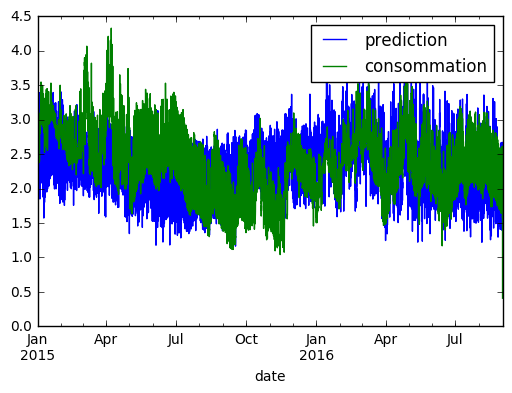

In [11]:
a2014 = (bale.index.year == 2014) 
a2015 = (bale.index.year == 2015) 
a2016 = (bale.index.year == 2016)

view = bale[['Temperature', "Shortwave Radiation - backwards", 'Wind Gust', 'Wind speed', \
             'Relative humidity', 'Mean Sea Level Pressure', 'Total Precipitation', \
             'Snowfall amount', 'Total cloud cover', 'High cloud cover', \
            'Low cloud cover', 'Shortwave Radiation - backwards', 'Wind speed', 'Wind direction', 'Hour']]

bale["prediction"] = pd.Series(np.nan, index=bale.index)
[bale["prediction"].loc[a2015], _] = prediction(view[a2014], bale["consommation"][a2014], view[a2015])
[bale["prediction"].loc[a2016], _] = prediction(view[a2015], bale["consommation"][a2015], view[a2016])


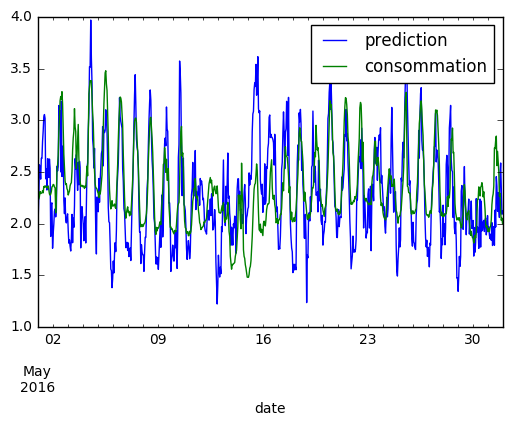

In [13]:
plt.figure()
bale["prediction"][a2016 & (month == 5)].plot()
bale["consommation"][a2016 & (month == 5)].plot()
plt.legend()
plt.show() 

# Initialisation 2
## Production d'électricité photovoltaïque et éolienne
Thèse O. Gergaud, modèle polynomial
$P_{G,max} = P_1\left[ 1 + P_2 (T - T_{ref}) \right] (P_3 + E_s)$
avec :
- $P_1 = 0.99$ (ou 0.099 pour un panneau)
- $P_2 = -4.7e^{-3} K^{-1}$ dérive en température
- $P_3 = 45$
- $T_{ref} = 24°C$
- $E_s$ ensoleillement dans le plan de panneaux (W/m^2)

Eolienne considérée :
- http://www.fw4sea.com/produits-fr/fiches-techniques/80-fiches-techniques-fr/88-f180-50

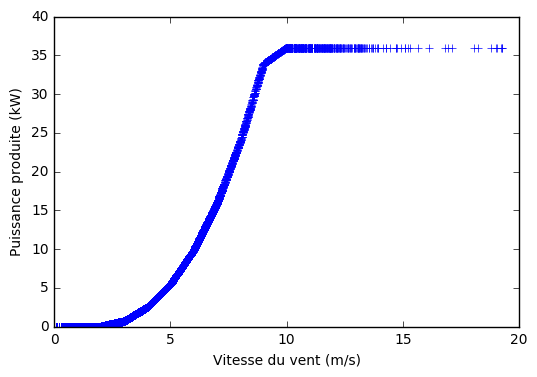

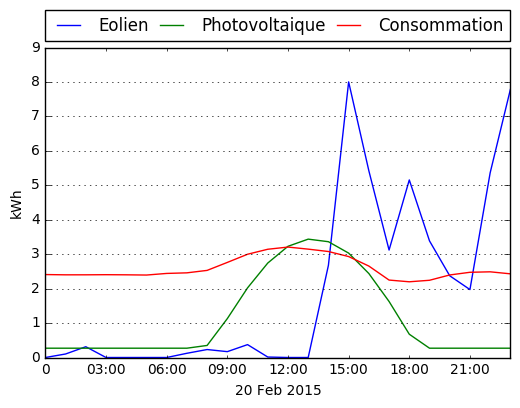

In [29]:
P1 =  6 #rendement de 30m2 de panneau solaire
P2 = -4.7e-3 #deviation en temperatrue
P3 = 45e-3 #gain supplémentaire
Tref = 24
NOCT = 43
bale["prod-pv"] = P1*( 1 + P2*(bale["Shortwave Radiation - backwards"]*1e-3* \
                        (NOCT-20)/800))*(P3+bale["Shortwave Radiation - backwards"]*1e-3)
period = (bale.index.month == 2) & (bale.index.day == 20) & (bale.index.year == 2015)

# F180-50
# puissance = np.ones(20)* 50.0
# puissance[:10]= [0,0,1,2.16,5.12,9.5,15.55, 23.52, 33.65, 45.0]
# Modele F100-10
puissance = np.ones(20)* 10.0

# Modele F180-36
puissance = np.ones(20)* 36.0
puissance[:10]= [0,0,0,0.68,2.5, 5.45, 9.85, 15.9, 23.85, 33.9]
plt.figure()
bale['prod-eol'] = np.interp( bale['Wind speed'].values, np.arange(20.0), puissance)
ax = plt.plot(bale['Wind speed'], bale['prod-eol'].values, '+')
plt.xlabel("Vitesse du vent (m/s)")
plt.ylabel("Puissance produite (kW)")
plt.show()


plt.figure()
ax = bale[period].plot(y='prod-eol', label="Eolien")
bale[period].plot(y="prod-pv", label="Photovoltaique", ax=ax)
bale[period].plot(y="consommation", label="Consommation", ax=ax)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.yaxis.grid()
plt.xlabel(bale[period].index[0].strftime("%d %b %Y"))
plt.ylabel("kWh")
ticklabels = ['']*len( bale[period].index)
ticklabels[::3] = [item.strftime('%-H') for item in  bale[period].index[::3]]
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
# ax.gcf().autofmt_xdate()



## Loi de commande 
    - Vente: on vend tout, puis on achète selon nos besoins
    - Consommation: on consomme ce qu'on produit, puis on vend les surplus
    - BatterieNormale: on stocke les surplus
    - BatterieAchat: à la fin d'une période d'heures creuses, on achète pour remplir la batterie jusqu'à un certain stade
    - BatterieAchatOpt: à la fin d'une période d'heures creuses, on achète pour remplir la batterie afin ne pas manquer d'électricité lors d'une période d'heures pleines

In [78]:
def LoiVente(consommation, production, mask, rachat=prix_eolien):
    depense = -production[mask]*rachat
    depense += consommation[mask]*prix[mask]
    return depense.cumsum()

def LoiConso(consommation, production, mask, rachat=prix_eolien):
    besoin = (consommation - production)
    return Depense(besoin[mask], rachat)

def LoiNormale(prod, cap_batterie, mask, conso = bale["consommation"],  rendement=0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    besoin = (bale[prod] - conso)[mask]
    stockage = pd.Series(0, index=bale[mask].index) 
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    stockagePre = 0.0
    for p in bale[mask].index:
        m=  bale[mask].index == p
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] > (cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = (cap_batterie - stockagePre) -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] < (cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def LoiAchat(prod, cap_batterie, mask, coeff = 1.0, rendement = 0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    stockage = pd.Series(0, index=bale[mask].index) 
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    besoin = (bale[prod] - bale["consommation"])[mask]
    stockagePre = 0.0
    for p in bale[mask].index:
        m=  bale[mask].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16 or h == 6) and (stockage[m].values[0] < cap_batterie*coeff):
            manque[m] += cap_batterie*coeff - stockage[m].values[0] 
            stockage[m] = cap_batterie*coeff 
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def Anticipation(prod, cap_batterie, mask, conso = bale["consommation"], rendement = 0.9):
# calcul ce dont il faut acheter pour subvenir aux besoins futurs de la HP
    [manque, stockage] = LoiNormale(prod, cap_batterie, mask, conso=conso, rendement= rendement)
    return manque[manque > 0 ].sum()
    
def LoiOptimal(prod,cap_batterie, mask, rendement = 0.9, conso=bale['consommation']):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    stockage = pd.Series(0, index=bale[mask].index) 
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    besoin = (bale[prod] - bale["consommation"])[mask]
    stockagePre = 0.0
    for p in bale[mask].index:
        m=  bale[mask].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16):
            periodHP = mask & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=10))
            besoinHP = Anticipation(prod, cap_batterie, periodHP, conso=conso)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] += min(besoinHP, cap_batterie)
        if (h == 6):
            periodHP = period & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=8))
            besoinHP = Anticipation(prod, cap_batterie, periodHP, conso=conso)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] = min(besoinHP, cap_batterie)

        stockagePre = stockage[m].values[0]

    return [manque, stockage]

## Besoin, manque et stockage sur une journée

In [7]:
plt.figure()
period = (bale.index.month <= 1)
cap_batterie = 7
besoin = (bale['consommation'] - bale['prod-eol'])[period]
speriod = (besoin.index.month == 1) & (besoin.index.day == 5)
[manque, stockage] = LoiNormale(besoin,  cap_batterie, period)
besoin[speriod].plot(label="Besoin")
manque[speriod].plot(label="Manque")
stockage[speriod].plot(label="Stockage")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.grid(True, which='both')
plt.xlabel("Temps")
plt.ylabel("kWh")
print besoin[speriod].mean()

1.72972966991


In [8]:
plt.figure()
bale['consommation'][period].cumsum().plot(label="Consommation")
bale['prod-pv'][period].cumsum().plot(label="Photovoltaïque")
bale['prod-eol'][period].cumsum().plot(label="Eolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)

plt.xlabel("Temps")
plt.ylabel("kWh")
ax = plt.gca()
ax.yaxis.grid()
plt.show()

## Influence du coefficient de remplissage

In [9]:
period = (bale.index.year == 2013)
cap_batterie = 14
coeff = np.arange(0, 1.1, 0.2)

besoin = (bale['consommation'] - bale['prod-pv'])[period]
coeff_pv = []
for i in coeff:
    print i
    [manque, stockage] = LoiAchat(besoin, cap_batterie, period, i)
    coeff_pv.append(Depense(manque,prix_pv)[-1])
    
besoin = (bale['consommation'] - bale['prod-eol'])[period]
coeff_eol = []
for i in coeff:
    print i
    [manque, stockage] = LoiAchat(besoin, cap_batterie, period, i)
    coeff_eol.append(Depense(manque,prix_eolien)[-1])


0.0
0.2
0.4
0.6
0.8
1.0
0.0
0.2
0.4
0.6
0.8
1.0


In [10]:
plt.figure()
plt.plot(coeff, coeff_pv/max(coeff_pv), label="Photovoltaique")
plt.plot(coeff, coeff_eol/max(coeff_eol), label="Eolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Coefficient de remplissage")
plt.ylabel("Facture normalisée")
ax.yaxis.grid()

## Facture avec le photovoltaïque

In [ ]:
# period = (bale.index.month == 1) & (bale.index.day == 1)
period = (bale.index.year == 2016)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-pv'])[period]
# pv = {}
rendement = 0.9

# 1. en vendant systematiquement notre production de photovoltaique
pv['Vente'] = LoiVente(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
pv["Consommation"] = LoiConso(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = LoiNormale('prod-pv',  cap_batterie, period)
pv["Normal"] = Depense(manqueNormal,prix_pv)

# 4. On remplit la batterie en fin de HC
[manqueAchat, stockageAchat] = LoiAchat('prod-pv', cap_batterie, period, 1.0)
pv["Achat"] = Depense(manqueAchat, prix_pv)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = LoiOptimal("prod-pv", cap_batterie, period)
pv["Optimal"] = Depense(manqueOpt, prix_pv)

# 6. Avec une prédiction de la consommation
[manquePred, stockagePred] = LoiOptimal("prod-pv", cap_batterie, period, conso=bale['prediction'])
pv["OptimalPred"] = Depense(manquePred, prix_pv)


-599.870083011
-563.285683832
-599.664672876


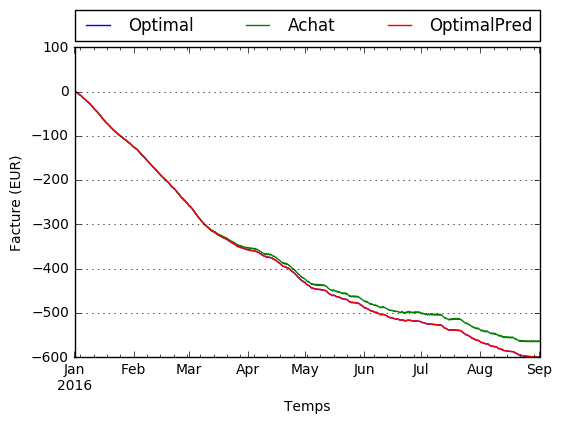

In [80]:
plt.figure()
for name in pv:
    pv[name].plot(label=name)
    print pv[name][-1]
# plt.title("Comparaison des lois de consommation en photovoltaïque")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (EUR)")#€
ax.yaxis.grid()
plt.show()

In [9]:
plt.figure()
period = bale.index.year == 2013
cap_batterie = 14
bale['consommation'][period].cumsum().plot(label="Consommation")
bale['prod-pv'][period].cumsum().plot(label="Photovoltaïque")
bale['prod-eol'][period].cumsum().plot(label="Eolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel("Temps")
plt.ylabel("kWh")
ax = plt.gca()
ax.yaxis.grid()

## Facture avec l'éolien

In [ ]:
# period = (bale.index.month == 1)# & (bale.index.day == 1)
period = (bale.index.year == 2013)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-eol'])[period]
eol_dep = {}

# 1. en vendant systematiquement notre production de photovoltaique
eol_dep["Vente"] = LoiVente(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
eol_dep["Consommation"] = LoiConso(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = LoiNormale('prod-eol',  cap_batterie, period)
eol_dep["Normal"] = Depense(manqueNormal,prix_eolien)

# 4. On remplit la batterie en fin de HC
[manqueAchat, stockageAchat] = LoiAchat('prod-eol', cap_batterie, period, 1.0)
eol_dep["Achat"] = Depense(manqueAchat, prix_eolien)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = LoiOptimal("prod-eol", cap_batterie, period)
eol_dep["Optimal"] = Depense(manqueOpt, prix_eolien)

# 6. Avec une prédiction de la consommation
[manquePred, stockagePred] = LoiOptimal("prod-eol", cap_batterie, period, conso=bale['prediction'])
eol_dep["OptimalPred"] = Depense(manquePred, prix_eolien)


In [15]:
plt.figure()
for name in eol_dep:
    eol_dep[name].plot(label=name)
    print eol_dep[name][-1]
    

# plt.title("Comparaison des lois de consommation en éolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (EUR)")#€
ax.yaxis.grid()

37.6286563575
142.495777793
151.621697037
282.741601979
877.564102391


## Quelle batterie faut-il ?

In [16]:
batteries = range(2,20,2)#[7,10,14]
period = (bale.index.year == 2013)
cap_batterie = 14


# en photovoltaique
pv_batt = {}
besoin = (bale['consommation'] - bale['prod-pv'])[period]
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal(besoin, b, period)
    pv_batt[b] = Depense(manqueOpt, prix_pv)[-1]


# en eolien
eol_batt = {}
besoin = (bale['consommation'] - bale['prod-eol'])[period]
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal(besoin, b, period)
    eol_batt[b] = Depense(manqueOpt, prix_eolien)[-1]


# sans production
noprod_batt = {}
besoin = bale['consommation'][period]
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal(besoin, b, period)
    noprod_batt[b] = Depense(manqueOpt, 0)[-1]

In [19]:
plt.figure()
plt.plot(batteries, pv_batt.values()/max(pv_batt.values()), label="Photovoltaïque")
max_eol = np.max(np.abs(np.array(eol_batt.values())))
eol = (2*max_eol+ np.array(eol_batt.values()))
eol = eol/max(eol)
plt.plot(batteries,eol, label="Eolien")
plt.plot(batteries, noprod_batt.values()/max(noprod_batt.values()), label="Sans production")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Capacité de batterie")
plt.ylabel("Facture normalisée")
ax.yaxis.grid()